**Модуль 10. Згорткові нейронні мережі**

---
**Частина 2**

Створити згорткову нейромережу, що використовує VGG16 в якості згорткової основи.


Навчіть отриману мережу на даних із датасету fasion_mnist. Спробуйте досягти максимально можливої точності класифікації за рахунок маніпуляції параметрами мережі. Під час навчання використовуйте прийоми донавчання та виділення ознак.


Порівняйте точність отриманої згорткової мережі з точністю багатошарової мережі з попереднього завдання. Зробіть висновки.



In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import fashion_mnist

import matplotlib.pyplot as plt

from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.applications.vgg16 import VGG16
from keras import optimizers
from keras import losses
from keras import metrics
from tensorflow.keras.callbacks import EarlyStopping
import copy
import numpy as np
from PIL import Image

In [3]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
train_images, test_images = train_images / 255.0, test_images / 255.0

4422102/4422102 [==============================] - 0s 0us/step


In [4]:
def resize_images(images):
    resized_images = []
    for img in images:
        # Resize the image to 32x32 using bilinear interpolation
        img_resized = np.array(Image.fromarray(img).resize((32, 32), Image.BILINEAR))
        # Convert grayscale to RGB format by replicating the single channel
        img_rgb = np.repeat(img_resized[:, :, np.newaxis], 3, axis=2)
        resized_images.append(img_rgb)
    return np.array(resized_images)

In [5]:
train_images = resize_images(train_images)
test_images = resize_images(test_images)

**Перевірка датасету**

In [5]:
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)


(60000, 32, 32, 3)
(60000,)
(10000, 32, 32, 3)
(10000,)


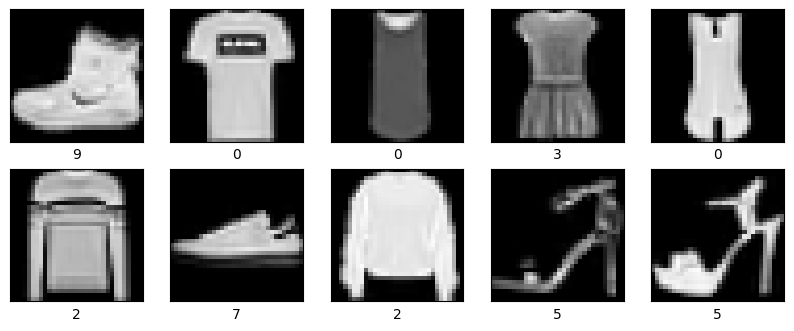

In [6]:
plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(train_labels[i])
plt.show()

**Функція відображення графіків втрат і точності на наборах даних**

In [6]:
def plot_history(history):
    train_loss = history.history['loss']
    train_acc = history.history['accuracy']
    val_loss = history.history['val_loss']
    val_acc = history.history['val_accuracy']

    epochs = range(1, len(train_loss) + 1)

    plt.plot(epochs, train_loss, 'r', label='Втрати на тренувальному наборі')
    plt.plot(epochs, val_loss, 'b', label='Втрати на тестовому наборі')
    plt.plot(epochs, train_acc, 'g', label='Точність на тренувальному наборі')
    plt.plot(epochs, val_acc, 'y', label='Точність на тестовому наборі')

    plt.title('Втрати та точність на тренувальному та тестовому наборі')
    plt.xlabel('Епоха')
    plt.ylabel('Метрики')
    plt.legend()
    plt.show()

**Функція пошуку оптимальних параметрів**

In [7]:
def find_optimal_parameters(train_images, train_labels, test_images, test_labels, parameters, optimal_parameters, study_sequence, train_model_func):
    best_accuracy = 0.0
    best_parameters = {}

    base_model_vgg16 = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

    for param in study_sequence:
        print()
        print('===================================================')
        print(f"Searching for optimal value for parameter: {param}")
        param_values = parameters[param]
        best_value = optimal_parameters[param]
        for value in param_values:
            optimal_parameters[param] = value
            print(f"Testing value: {value}")
            model, history, (test_loss, test_acc), (train_loss, train_acc) = train_model_func(train_images, train_labels, test_images, test_labels, base_model=base_model_vgg16, **optimal_parameters)
            if test_acc > best_accuracy:
                best_accuracy = test_acc
                best_parameters = copy.deepcopy(optimal_parameters)
                best_value = value
            # Результати навчання для параметра
            print(f"Досліджений параметр {param} = {value}")

            plot_history(history)
            print('Parameters', optimal_parameters)
            print('test_loss =', test_loss)
            print('test_acc =', test_acc)
            print('train_loss =', train_loss)
            print('train_acc =', train_acc)

        # Update optimal parameter for the current parameter
        optimal_parameters[param] = best_value
        print(f"Optimal value for parameter {param}: {best_value}, test accuracy: {best_accuracy}")
        print()

    print("Optimal parameters:")
    print(best_parameters)
    print(f"Test accuracy: {best_accuracy}")
    return best_parameters, best_accuracy


**Модель для тренування 1**

---


In [9]:
base_model_vgg16 = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))


58889256/58889256 [==============================] - 0s 0us/step


In [10]:
def train_model(train_images, train_labels, test_images, test_labels, base_model=base_model_vgg16, epochs=20, batch_size=32, dropout_rate=0.1,
                loss_function='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy']):
    #base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

    base_model.trainable = False

    model = models.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(dropout_rate),
        layers.Dense(10, activation='softmax')
    ])

    model.compile(optimizer=optimizer,
                  loss=loss_function,
                  metrics=metrics)

    history = model.fit(train_images, train_labels, epochs=epochs, batch_size=batch_size, validation_data=(test_images, test_labels))

    test_loss, test_acc = model.evaluate(test_images, test_labels)
    print('Точність на тестових даних:', test_acc)

    train_loss, train_acc = model.evaluate(train_images, train_labels)
    print('Точність на тренувальних даних:', train_acc)

    return model, history, (test_loss, test_acc), (train_loss, train_acc)



**Перевірка моделі 1 на параметрах за замовчанням**

In [11]:
model_1_testing = train_model(train_images, train_labels, test_images, test_labels,
                              base_model=base_model_vgg16,
                              epochs=20,
                              batch_size=32,
                              dropout_rate=0.1,
                              loss_function='sparse_categorical_crossentropy',
                              optimizer='adam',
                              metrics=['accuracy'])

Epoch 1/20
1875/1875 [==============================] - 16s 6ms/step - loss: 0.5977 - accuracy: 0.7904 - val_loss: 0.4492 - val_accuracy: 0.8366
Epoch 2/20
1875/1875 [==============================] - 10s 5ms/step - loss: 0.4377 - accuracy: 0.8407 - val_loss: 0.4087 - val_accuracy: 0.8520
Epoch 3/20
1875/1875 [==============================] - 11s 6ms/step - loss: 0.4008 - accuracy: 0.8541 - val_loss: 0.4006 - val_accuracy: 0.8541
Epoch 4/20
1875/1875 [==============================] - 11s 6ms/step - loss: 0.3791 - accuracy: 0.8601 - val_loss: 0.3898 - val_accuracy: 0.8575
Epoch 5/20
1875/1875 [==============================] - 10s 5ms/step - loss: 0.3654 - accuracy: 0.8649 - val_loss: 0.3742 - val_accuracy: 0.8642
Epoch 6/20
1875/1875 [==============================] - 10s 5ms/step - loss: 0.3558 - accuracy: 0.8670 - val_loss: 0.3786 - val_accuracy: 0.8617
Epoch 7/20
1875/1875 [==============================] - 10s 5ms/step - loss: 0.3429 - accuracy: 0.8729 - val_loss: 0.3655 - val_ac

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 64)                32832     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                650       
                                                                 
Total params: 14748170 (56.26 MB)
Trainable params: 33482 (130.79 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


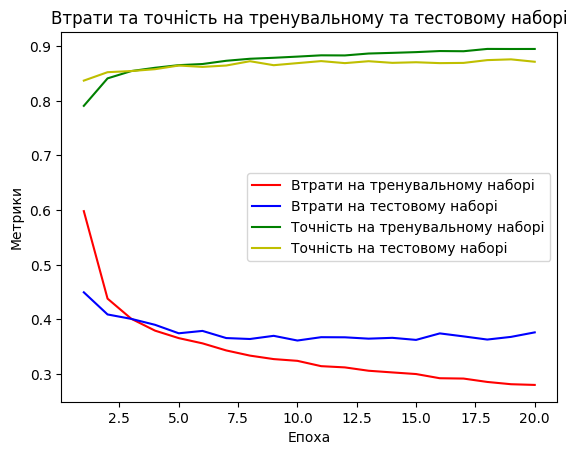

In [12]:
model_1_testing[0].summary()
plot_history(model_1_testing[1])

In [14]:
study_sequence = [
                  'optimizer',
 #                 'activation',
 #                 'hidden_units',
                  'dropout_rate',
                  'batch_size',
                  'loss_function']
#                  'metrics',
#                  'epochs']

optimal_parameters = {
    'epochs': 10,
    'batch_size': 32,
    'dropout_rate': 0.1,
    'loss_function': 'sparse_categorical_crossentropy',
    'optimizer': 'adam',
#    'activation': 'relu',
    'metrics': ['accuracy']
    }

# Списки параметрів, що мають бути досліджені під час навчання

parameters = {
    'epochs': [10, 20, 30],
    'batch_size': [32, 64, 128],
    'dropout_rate': [0.2, 0.3, 0.4],
    'loss_function': ['sparse_categorical_crossentropy'],
    'optimizer': ['adam', 'rmsprop'],
#    'hidden_units': [128, 256, 512],
#    'activation': ['relu', 'tanh'],
    'metrics': ['accuracy']
    }


Searching for optimal value for parameter: optimizer
Testing value: adam
Epoch 1/10
1875/1875 [==============================] - 19s 9ms/step - loss: 0.5940 - accuracy: 0.7911 - val_loss: 0.4527 - val_accuracy: 0.8362
Epoch 2/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.4370 - accuracy: 0.8402 - val_loss: 0.4145 - val_accuracy: 0.8467
Epoch 3/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.4021 - accuracy: 0.8520 - val_loss: 0.4027 - val_accuracy: 0.8515
Epoch 4/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.3796 - accuracy: 0.8618 - val_loss: 0.3852 - val_accuracy: 0.8593
Epoch 5/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.3638 - accuracy: 0.8659 - val_loss: 0.3770 - val_accuracy: 0.8614
Epoch 6/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.3532 - accuracy: 0.8686 - val_loss: 0.3972 - val_accuracy: 0.8571
Epoch 7/10
1875/1875 [==============================] - 1

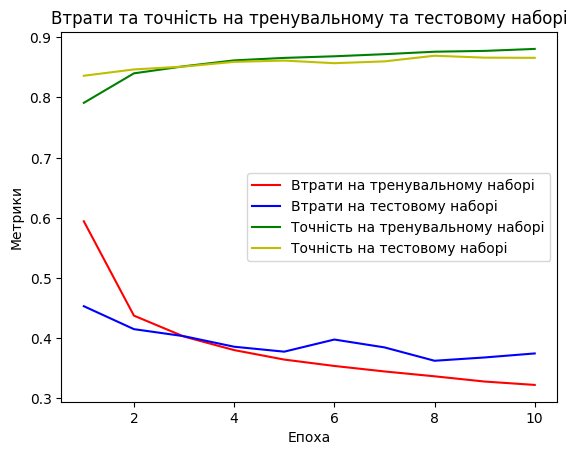

Parameters {'epochs': 10, 'batch_size': 32, 'dropout_rate': 0.1, 'loss_function': 'sparse_categorical_crossentropy', 'optimizer': 'adam', 'metrics': ['accuracy']}
test_loss = 0.37405484914779663
test_acc = 0.8659999966621399
train_loss = 0.2930842638015747
train_acc = 0.8911666870117188
Testing value: rmsprop
Epoch 1/10
1875/1875 [==============================] - 19s 10ms/step - loss: 0.5977 - accuracy: 0.7900 - val_loss: 0.4543 - val_accuracy: 0.8357
Epoch 2/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.4435 - accuracy: 0.8396 - val_loss: 0.4358 - val_accuracy: 0.8411
Epoch 3/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.4138 - accuracy: 0.8494 - val_loss: 0.4069 - val_accuracy: 0.8521
Epoch 4/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.3993 - accuracy: 0.8562 - val_loss: 0.4145 - val_accuracy: 0.8506
Epoch 5/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.3880 - accuracy: 0.8614 - val

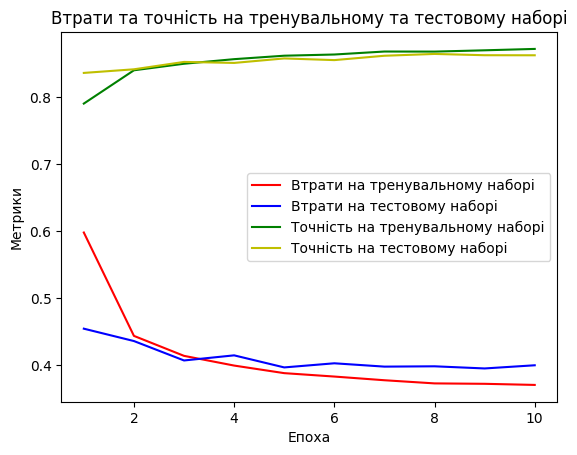

Parameters {'epochs': 10, 'batch_size': 32, 'dropout_rate': 0.1, 'loss_function': 'sparse_categorical_crossentropy', 'optimizer': 'rmsprop', 'metrics': ['accuracy']}
test_loss = 0.3997044861316681
test_acc = 0.8619999885559082
train_loss = 0.3301754295825958
train_acc = 0.8840166926383972
Optimal value for parameter optimizer: adam, test accuracy: 0.8659999966621399

Searching for optimal value for parameter: dropout_rate
Testing value: 0.2
Epoch 1/10
1875/1875 [==============================] - 20s 10ms/step - loss: 0.6424 - accuracy: 0.7759 - val_loss: 0.4696 - val_accuracy: 0.8310
Epoch 2/10
1875/1875 [==============================] - 18s 9ms/step - loss: 0.4612 - accuracy: 0.8337 - val_loss: 0.4266 - val_accuracy: 0.8414
Epoch 3/10
1875/1875 [==============================] - 18s 10ms/step - loss: 0.4230 - accuracy: 0.8458 - val_loss: 0.4009 - val_accuracy: 0.8532
Epoch 4/10
1875/1875 [==============================] - 19s 10ms/step - loss: 0.4002 - accuracy: 0.8530 - val_loss: 0.

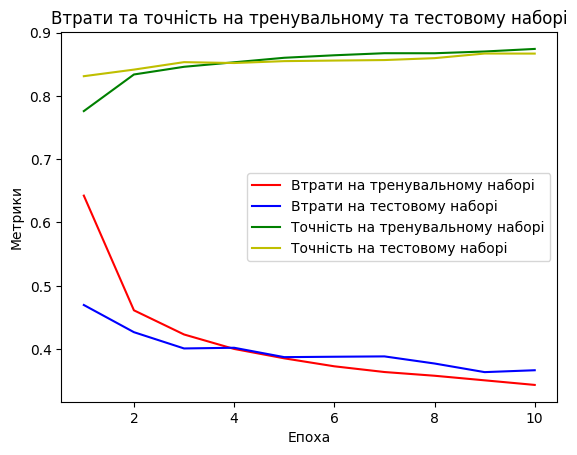

Parameters {'epochs': 10, 'batch_size': 32, 'dropout_rate': 0.2, 'loss_function': 'sparse_categorical_crossentropy', 'optimizer': 'adam', 'metrics': ['accuracy']}
test_loss = 0.36649081110954285
test_acc = 0.8666999936103821
train_loss = 0.2988753318786621
train_acc = 0.888450026512146
Testing value: 0.3
Epoch 1/10
1875/1875 [==============================] - 19s 10ms/step - loss: 0.6629 - accuracy: 0.7696 - val_loss: 0.4689 - val_accuracy: 0.8308
Epoch 2/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.4817 - accuracy: 0.8277 - val_loss: 0.4230 - val_accuracy: 0.8449
Epoch 3/10
1875/1875 [==============================] - 19s 10ms/step - loss: 0.4444 - accuracy: 0.8398 - val_loss: 0.4139 - val_accuracy: 0.8475
Epoch 4/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.4220 - accuracy: 0.8472 - val_loss: 0.4134 - val_accuracy: 0.8449
Epoch 5/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.4078 - accuracy: 0.8530 - val_los

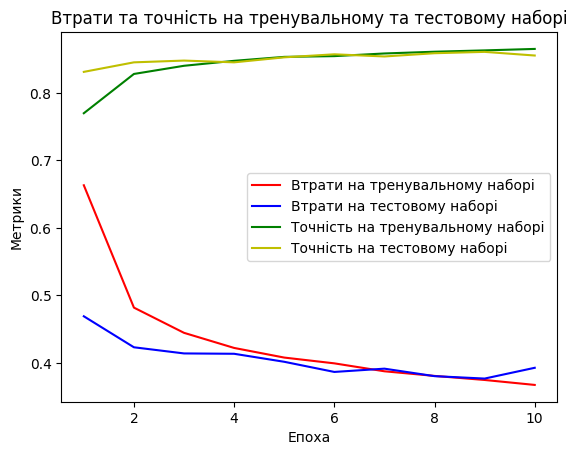

Parameters {'epochs': 10, 'batch_size': 32, 'dropout_rate': 0.3, 'loss_function': 'sparse_categorical_crossentropy', 'optimizer': 'adam', 'metrics': ['accuracy']}
test_loss = 0.392649382352829
test_acc = 0.8550000190734863
train_loss = 0.3318711519241333
train_acc = 0.8771499991416931
Testing value: 0.4
Epoch 1/10
1875/1875 [==============================] - 20s 10ms/step - loss: 0.6998 - accuracy: 0.7559 - val_loss: 0.4776 - val_accuracy: 0.8257
Epoch 2/10
1875/1875 [==============================] - 18s 10ms/step - loss: 0.5088 - accuracy: 0.8188 - val_loss: 0.4303 - val_accuracy: 0.8444
Epoch 3/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.4682 - accuracy: 0.8309 - val_loss: 0.4209 - val_accuracy: 0.8436
Epoch 4/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.4501 - accuracy: 0.8377 - val_loss: 0.4067 - val_accuracy: 0.8487
Epoch 5/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.4323 - accuracy: 0.8429 - val_loss

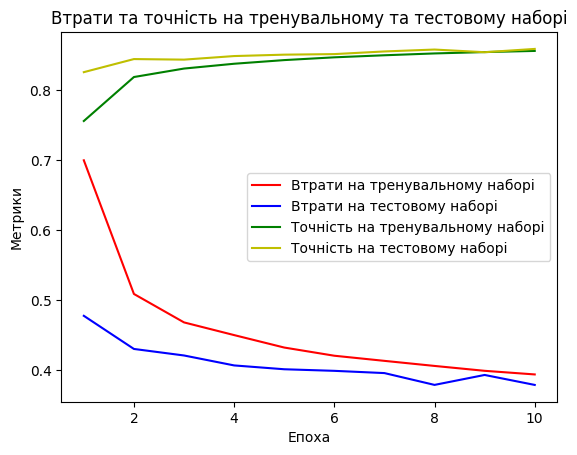

Parameters {'epochs': 10, 'batch_size': 32, 'dropout_rate': 0.4, 'loss_function': 'sparse_categorical_crossentropy', 'optimizer': 'adam', 'metrics': ['accuracy']}
test_loss = 0.37886062264442444
test_acc = 0.8589000105857849
train_loss = 0.3231068253517151
train_acc = 0.8796833157539368
Optimal value for parameter dropout_rate: 0.2, test accuracy: 0.8666999936103821

Searching for optimal value for parameter: batch_size
Testing value: 32
Epoch 1/10
1875/1875 [==============================] - 20s 10ms/step - loss: 0.6361 - accuracy: 0.7775 - val_loss: 0.4595 - val_accuracy: 0.8301
Epoch 2/10
1875/1875 [==============================] - 18s 9ms/step - loss: 0.4610 - accuracy: 0.8341 - val_loss: 0.4252 - val_accuracy: 0.8429
Epoch 3/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.4270 - accuracy: 0.8457 - val_loss: 0.4029 - val_accuracy: 0.8524
Epoch 4/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.4043 - accuracy: 0.8537 - val_loss: 0.4009 

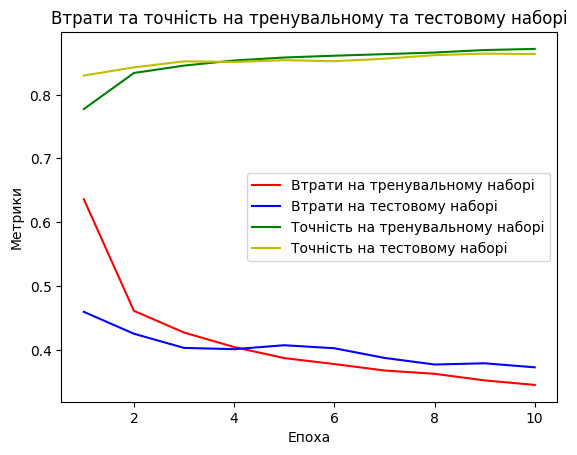

Parameters {'epochs': 10, 'batch_size': 32, 'dropout_rate': 0.2, 'loss_function': 'sparse_categorical_crossentropy', 'optimizer': 'adam', 'metrics': ['accuracy']}
test_loss = 0.3724757730960846
test_acc = 0.8637999892234802
train_loss = 0.3028455674648285
train_acc = 0.8864333629608154
Testing value: 64
Epoch 1/10
938/938 [==============================] - 14s 13ms/step - loss: 0.6863 - accuracy: 0.7624 - val_loss: 0.4878 - val_accuracy: 0.8266
Epoch 2/10
938/938 [==============================] - 12s 13ms/step - loss: 0.4753 - accuracy: 0.8287 - val_loss: 0.4329 - val_accuracy: 0.8428
Epoch 3/10
938/938 [==============================] - 13s 14ms/step - loss: 0.4342 - accuracy: 0.8423 - val_loss: 0.4154 - val_accuracy: 0.8476
Epoch 4/10
938/938 [==============================] - 12s 13ms/step - loss: 0.4105 - accuracy: 0.8497 - val_loss: 0.4057 - val_accuracy: 0.8510
Epoch 5/10
938/938 [==============================] - 12s 13ms/step - loss: 0.3939 - accuracy: 0.8560 - val_loss: 0.388

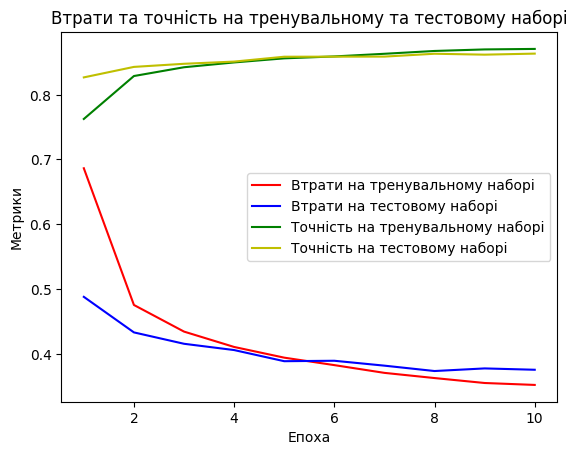

Parameters {'epochs': 10, 'batch_size': 64, 'dropout_rate': 0.2, 'loss_function': 'sparse_categorical_crossentropy', 'optimizer': 'adam', 'metrics': ['accuracy']}
test_loss = 0.37526029348373413
test_acc = 0.8633000254631042
train_loss = 0.310507595539093
train_acc = 0.883899986743927
Testing value: 128
Epoch 1/10
469/469 [==============================] - 13s 22ms/step - loss: 0.7625 - accuracy: 0.7394 - val_loss: 0.5130 - val_accuracy: 0.8156
Epoch 2/10
469/469 [==============================] - 9s 19ms/step - loss: 0.5061 - accuracy: 0.8206 - val_loss: 0.4562 - val_accuracy: 0.8337
Epoch 3/10
469/469 [==============================] - 9s 19ms/step - loss: 0.4543 - accuracy: 0.8369 - val_loss: 0.4282 - val_accuracy: 0.8454
Epoch 4/10
469/469 [==============================] - 9s 19ms/step - loss: 0.4269 - accuracy: 0.8454 - val_loss: 0.4184 - val_accuracy: 0.8483
Epoch 5/10
469/469 [==============================] - 9s 19ms/step - loss: 0.4063 - accuracy: 0.8518 - val_loss: 0.4024 - 

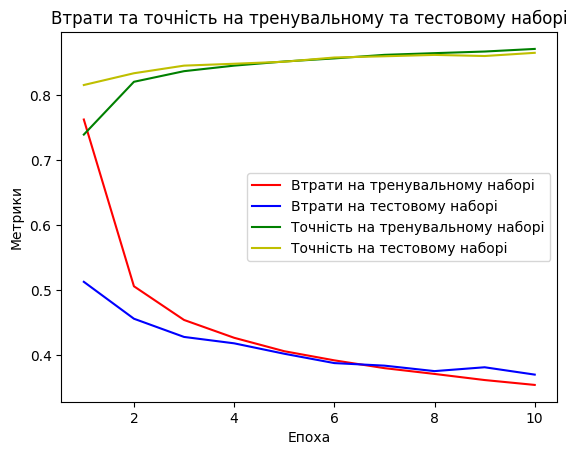

Parameters {'epochs': 10, 'batch_size': 128, 'dropout_rate': 0.2, 'loss_function': 'sparse_categorical_crossentropy', 'optimizer': 'adam', 'metrics': ['accuracy']}
test_loss = 0.37026193737983704
test_acc = 0.8651000261306763
train_loss = 0.31511417031288147
train_acc = 0.8830333352088928
Optimal value for parameter batch_size: 32, test accuracy: 0.8666999936103821

Searching for optimal value for parameter: loss_function
Testing value: sparse_categorical_crossentropy
Epoch 1/10
1875/1875 [==============================] - 19s 10ms/step - loss: 0.6322 - accuracy: 0.7784 - val_loss: 0.4615 - val_accuracy: 0.8335
Epoch 2/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.4601 - accuracy: 0.8328 - val_loss: 0.4292 - val_accuracy: 0.8463
Epoch 3/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.4258 - accuracy: 0.8461 - val_loss: 0.4103 - val_accuracy: 0.8502
Epoch 4/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.4007 - accur

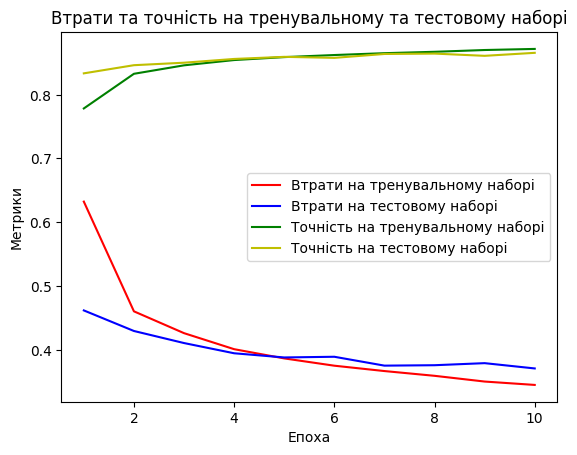

Parameters {'epochs': 10, 'batch_size': 32, 'dropout_rate': 0.2, 'loss_function': 'sparse_categorical_crossentropy', 'optimizer': 'adam', 'metrics': ['accuracy']}
test_loss = 0.3704562783241272
test_acc = 0.8657000064849854
train_loss = 0.29696398973464966
train_acc = 0.8881166577339172
Optimal value for parameter loss_function: sparse_categorical_crossentropy, test accuracy: 0.8666999936103821

Optimal parameters:
{'epochs': 10, 'batch_size': 32, 'dropout_rate': 0.2, 'loss_function': 'sparse_categorical_crossentropy', 'optimizer': 'adam', 'metrics': ['accuracy']}
Test accuracy: 0.8666999936103821


In [ ]:
find_optimal_1 = find_optimal_parameters(train_images, train_labels, test_images, test_labels, parameters, optimal_parameters, study_sequence, train_model)


Встановлені Оптимальні параметри для моделі 1 (без розморожування шарів):
Optimal parameters:
{'epochs': 10, 'batch_size': 32, 'dropout_rate': 0.2, 'loss_function': 'sparse_categorical_crossentropy', 'optimizer': 'adam', 'metrics': ['accuracy']}
Test accuracy: 0.8666999936103821

Точність не достатньо висока. Можливо, через низьку роздільну здатність датасету.

**Ініціалізація і перевірка моделі 2**

---



In [15]:
def train_model_2(train_images, train_labels, test_images, test_labels, base_model=base_model_vgg16, epochs=20, batch_size=32, dropout_rate=0.1,
                loss_function='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy']):

    base_model.trainable = True
    set_trainable = False

    for layer in base_model_vgg16.layers:
        if layer.name == "block5_conv1":
            set_trainable = True
        if set_trainable:
            layer.trainable = True
        else:
            layer.trainable = False

    model = models.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(dropout_rate),
        layers.Dense(10, activation='softmax')
    ])

    early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

    model.compile(optimizer=optimizer,
                  loss=loss_function,
                  metrics=metrics)

    history = model.fit(train_images, train_labels, epochs=epochs, batch_size=batch_size, validation_data=(test_images, test_labels), callbacks=[early_stopping])

    test_loss, test_acc = model.evaluate(test_images, test_labels)
    print('Точність на тестових даних:', test_acc)

    train_loss, train_acc = model.evaluate(train_images, train_labels)
    print('Точність на тренувальних даних:', train_acc)

    return model, history, (test_loss, test_acc), (train_loss, train_acc)


In [16]:
model_2_testing = train_model_2(train_images, train_labels, test_images, test_labels,
                              base_model=base_model_vgg16,
                              epochs=20,
                              batch_size=32,
                              dropout_rate=0.1,
                              loss_function='sparse_categorical_crossentropy',
                              optimizer='adam',
                              metrics=['accuracy'])

Epoch 1/20
1875/1875 [==============================] - 17s 8ms/step - loss: 0.4651 - accuracy: 0.8400 - val_loss: 0.3505 - val_accuracy: 0.8688
Epoch 2/20
1875/1875 [==============================] - 13s 7ms/step - loss: 0.3336 - accuracy: 0.8848 - val_loss: 0.3285 - val_accuracy: 0.8850
Epoch 3/20
1875/1875 [==============================] - 13s 7ms/step - loss: 0.3001 - accuracy: 0.8946 - val_loss: 0.3250 - val_accuracy: 0.8923
Epoch 4/20
1875/1875 [==============================] - 13s 7ms/step - loss: 0.2803 - accuracy: 0.9015 - val_loss: 0.3145 - val_accuracy: 0.8934
Epoch 5/20
1875/1875 [==============================] - 14s 7ms/step - loss: 0.2594 - accuracy: 0.9084 - val_loss: 0.2843 - val_accuracy: 0.8985
Epoch 6/20
1875/1875 [==============================] - 13s 7ms/step - loss: 0.2489 - accuracy: 0.9106 - val_loss: 0.2965 - val_accuracy: 0.8985
Epoch 7/20
1875/1875 [==============================] - 13s 7ms/step - loss: 0.2413 - accuracy: 0.9137 - val_loss: 0.2928 - val_ac

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                32832     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 10)                650       
                                                                 
Total params: 14748170 (56.26 MB)
Trainable params: 7112906 (27.13 MB)
Non-trainable params: 7635264 (29.13 MB)
_________________________________________________________________


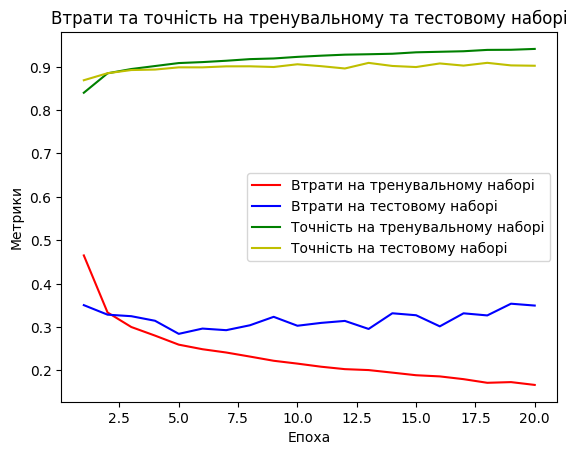

In [17]:
model_2_testing[0].summary()
plot_history(model_2_testing[1])

Searching for optimal value for parameter: optimizer
Testing value: adam
Epoch 1/10
1875/1875 [==============================] - 28s 12ms/step - loss: 0.7265 - accuracy: 0.7248 - val_loss: 0.4755 - val_accuracy: 0.8183
Epoch 2/10
1875/1875 [==============================] - 23s 12ms/step - loss: 0.3953 - accuracy: 0.8670 - val_loss: 0.3310 - val_accuracy: 0.8871
Epoch 3/10
1875/1875 [==============================] - 22s 12ms/step - loss: 0.3307 - accuracy: 0.8906 - val_loss: 0.3277 - val_accuracy: 0.8964
Epoch 4/10
1875/1875 [==============================] - 23s 12ms/step - loss: 0.2940 - accuracy: 0.9015 - val_loss: 0.2979 - val_accuracy: 0.8961
Epoch 5/10
1875/1875 [==============================] - 22s 12ms/step - loss: 0.2716 - accuracy: 0.9103 - val_loss: 0.2879 - val_accuracy: 0.9012
Epoch 6/10
1875/1875 [==============================] - 21s 11ms/step - loss: 0.2427 - accuracy: 0.9184 - val_loss: 0.2747 - val_accuracy: 0.9109
Epoch 7/10
1875/1875 [=============================

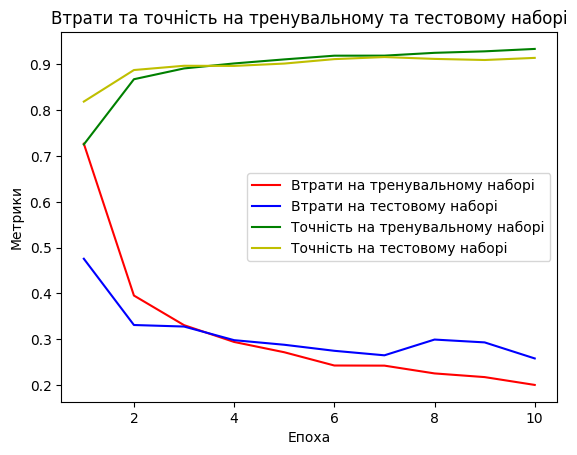

Parameters {'epochs': 10, 'batch_size': 32, 'dropout_rate': 0.1, 'loss_function': 'sparse_categorical_crossentropy', 'optimizer': 'adam', 'metrics': ['accuracy']}
test_loss = 0.25807979702949524
test_acc = 0.9136000275611877
train_loss = 0.17054781317710876
train_acc = 0.940833330154419
Testing value: rmsprop
Epoch 1/10
1875/1875 [==============================] - 24s 11ms/step - loss: 0.2200 - accuracy: 0.9351 - val_loss: 0.3218 - val_accuracy: 0.9154
Epoch 2/10
1875/1875 [==============================] - 20s 11ms/step - loss: 0.2166 - accuracy: 0.9351 - val_loss: 0.2985 - val_accuracy: 0.9112
Epoch 3/10
1875/1875 [==============================] - 22s 12ms/step - loss: 0.2457 - accuracy: 0.9314 - val_loss: 0.4316 - val_accuracy: 0.9073
Epoch 4/10
1875/1875 [==============================] - 20s 11ms/step - loss: 0.2685 - accuracy: 0.9266 - val_loss: 0.3715 - val_accuracy: 0.9025
Epoch 5/10
1875/1875 [==============================] - 21s 11ms/step - loss: 0.3044 - accuracy: 0.9182 -

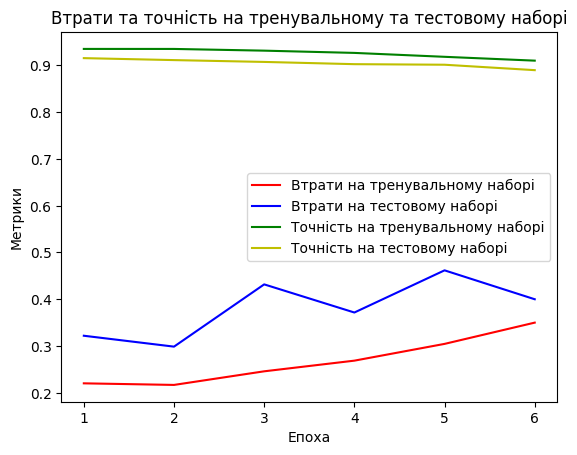

Parameters {'epochs': 10, 'batch_size': 32, 'dropout_rate': 0.1, 'loss_function': 'sparse_categorical_crossentropy', 'optimizer': 'rmsprop', 'metrics': ['accuracy']}
test_loss = 0.3218102753162384
test_acc = 0.9154000282287598
train_loss = 0.16701607406139374
train_acc = 0.9455500245094299
Optimal value for parameter optimizer: rmsprop, test accuracy: 0.9154000282287598

Searching for optimal value for parameter: dropout_rate
Testing value: 0.2
Epoch 1/10
1875/1875 [==============================] - 23s 11ms/step - loss: 0.2394 - accuracy: 0.9319 - val_loss: 0.3250 - val_accuracy: 0.9109
Epoch 2/10
1875/1875 [==============================] - 20s 11ms/step - loss: 0.2392 - accuracy: 0.9345 - val_loss: 0.4117 - val_accuracy: 0.9108
Epoch 3/10
1875/1875 [==============================] - 20s 11ms/step - loss: 0.2668 - accuracy: 0.9274 - val_loss: 0.5092 - val_accuracy: 0.8158
Epoch 4/10
1875/1875 [==============================] - 20s 11ms/step - loss: 0.3562 - accuracy: 0.9145 - val_los

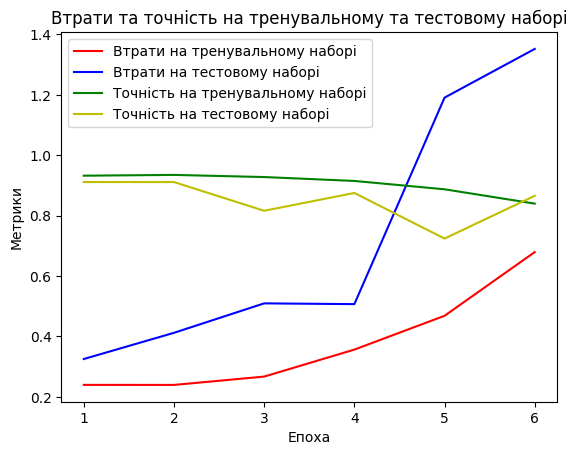

Parameters {'epochs': 10, 'batch_size': 32, 'dropout_rate': 0.2, 'loss_function': 'sparse_categorical_crossentropy', 'optimizer': 'rmsprop', 'metrics': ['accuracy']}
test_loss = 0.32500267028808594
test_acc = 0.9108999967575073
train_loss = 0.1813119798898697
train_acc = 0.9349833130836487
Testing value: 0.3
Epoch 1/10
1875/1875 [==============================] - 23s 11ms/step - loss: 0.2658 - accuracy: 0.9302 - val_loss: 0.3872 - val_accuracy: 0.8893
Epoch 2/10
1875/1875 [==============================] - 20s 10ms/step - loss: 0.2753 - accuracy: 0.9254 - val_loss: 0.6627 - val_accuracy: 0.9053
Epoch 3/10
1875/1875 [==============================] - 20s 11ms/step - loss: 0.3765 - accuracy: 0.9069 - val_loss: 0.6622 - val_accuracy: 0.8919
Epoch 4/10
1875/1875 [==============================] - 21s 11ms/step - loss: 0.5513 - accuracy: 0.8733 - val_loss: 0.4657 - val_accuracy: 0.8493
Epoch 5/10
1875/1875 [==============================] - 20s 11ms/step - loss: 1.0288 - accuracy: 0.7612 - 

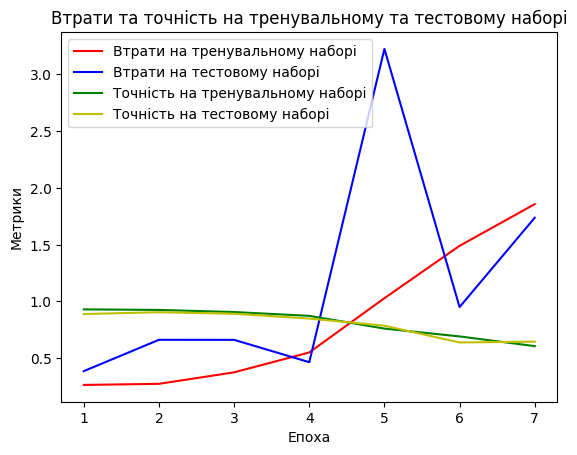

Parameters {'epochs': 10, 'batch_size': 32, 'dropout_rate': 0.3, 'loss_function': 'sparse_categorical_crossentropy', 'optimizer': 'rmsprop', 'metrics': ['accuracy']}
test_loss = 0.6626570820808411
test_acc = 0.9053000211715698
train_loss = 0.2790985405445099
train_acc = 0.9333999752998352
Testing value: 0.4
Epoch 1/10
1875/1875 [==============================] - 23s 11ms/step - loss: 0.3861 - accuracy: 0.9114 - val_loss: 0.4553 - val_accuracy: 0.8971
Epoch 2/10
1875/1875 [==============================] - 21s 11ms/step - loss: 0.3365 - accuracy: 0.9142 - val_loss: 0.4329 - val_accuracy: 0.8978
Epoch 3/10
1875/1875 [==============================] - 20s 11ms/step - loss: 0.4391 - accuracy: 0.8931 - val_loss: 1.2033 - val_accuracy: 0.8874
Epoch 4/10
1875/1875 [==============================] - 20s 11ms/step - loss: 0.5332 - accuracy: 0.8742 - val_loss: 0.5462 - val_accuracy: 0.8729
Epoch 5/10
1875/1875 [==============================] - 20s 11ms/step - loss: 0.8027 - accuracy: 0.8349 - v

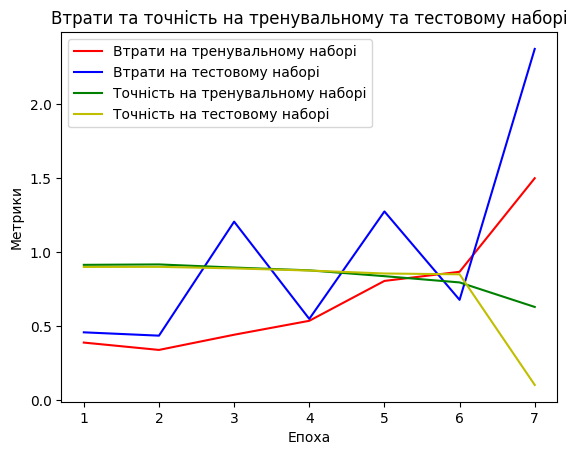

Parameters {'epochs': 10, 'batch_size': 32, 'dropout_rate': 0.4, 'loss_function': 'sparse_categorical_crossentropy', 'optimizer': 'rmsprop', 'metrics': ['accuracy']}
test_loss = 0.43291181325912476
test_acc = 0.8978000283241272
train_loss = 0.26543617248535156
train_acc = 0.9239500164985657
Optimal value for parameter dropout_rate: 0.1, test accuracy: 0.9154000282287598

Searching for optimal value for parameter: batch_size
Testing value: 32
Epoch 1/10
1875/1875 [==============================] - 24s 11ms/step - loss: 0.3218 - accuracy: 0.9134 - val_loss: 0.3871 - val_accuracy: 0.8999
Epoch 2/10
1875/1875 [==============================] - 21s 11ms/step - loss: 0.3086 - accuracy: 0.9183 - val_loss: 0.4018 - val_accuracy: 0.8847
Epoch 3/10
1875/1875 [==============================] - 20s 11ms/step - loss: 0.3678 - accuracy: 0.9081 - val_loss: 0.5465 - val_accuracy: 0.9017
Epoch 4/10
1875/1875 [==============================] - 20s 11ms/step - loss: 0.4121 - accuracy: 0.8982 - val_loss: 

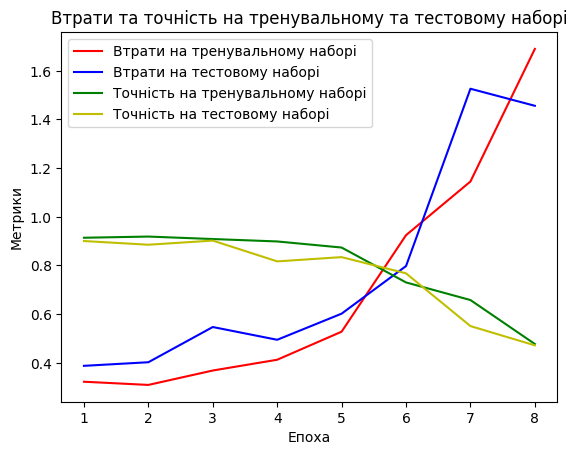

Parameters {'epochs': 10, 'batch_size': 32, 'dropout_rate': 0.1, 'loss_function': 'sparse_categorical_crossentropy', 'optimizer': 'rmsprop', 'metrics': ['accuracy']}
test_loss = 0.5465338230133057
test_acc = 0.9017000198364258
train_loss = 0.34944286942481995
train_acc = 0.9229666590690613
Testing value: 64
Epoch 1/10
938/938 [==============================] - 17s 15ms/step - loss: 0.3847 - accuracy: 0.9138 - val_loss: 0.3726 - val_accuracy: 0.9126
Epoch 2/10
938/938 [==============================] - 14s 15ms/step - loss: 0.2310 - accuracy: 0.9331 - val_loss: 0.4323 - val_accuracy: 0.9159
Epoch 3/10
938/938 [==============================] - 14s 15ms/step - loss: 0.2413 - accuracy: 0.9315 - val_loss: 0.5179 - val_accuracy: 0.9090
Epoch 4/10
938/938 [==============================] - 14s 15ms/step - loss: 0.2418 - accuracy: 0.9335 - val_loss: 0.9027 - val_accuracy: 0.9144
Epoch 5/10
938/938 [==============================] - 14s 14ms/step - loss: 0.2434 - accuracy: 0.9336 - val_loss: 0

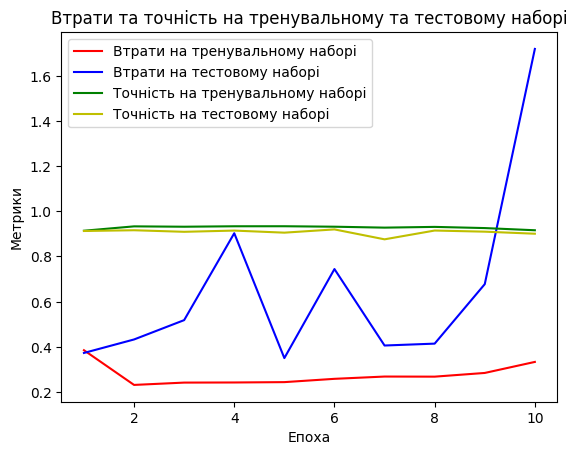

Parameters {'epochs': 10, 'batch_size': 64, 'dropout_rate': 0.1, 'loss_function': 'sparse_categorical_crossentropy', 'optimizer': 'rmsprop', 'metrics': ['accuracy']}
test_loss = 1.7187821865081787
test_acc = 0.9004999995231628
train_loss = 0.8834145069122314
train_acc = 0.9271833300590515
Testing value: 128
Epoch 1/10
469/469 [==============================] - 15s 24ms/step - loss: 1.2633 - accuracy: 0.9106 - val_loss: 0.4022 - val_accuracy: 0.9166
Epoch 2/10
469/469 [==============================] - 9s 20ms/step - loss: 0.1984 - accuracy: 0.9452 - val_loss: 0.5019 - val_accuracy: 0.9234
Epoch 3/10
469/469 [==============================] - 10s 21ms/step - loss: 0.1756 - accuracy: 0.9503 - val_loss: 0.4248 - val_accuracy: 0.9210
Epoch 4/10
469/469 [==============================] - 10s 20ms/step - loss: 0.1622 - accuracy: 0.9547 - val_loss: 0.4207 - val_accuracy: 0.9233
Epoch 5/10
469/469 [==============================] - 10s 21ms/step - loss: 0.1592 - accuracy: 0.9551 - val_loss: 0.

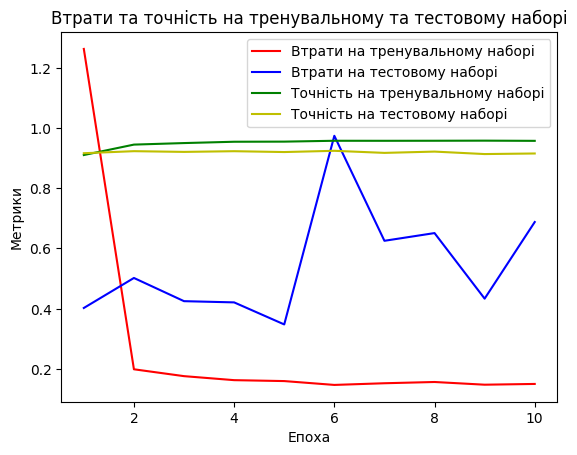

Parameters {'epochs': 10, 'batch_size': 128, 'dropout_rate': 0.1, 'loss_function': 'sparse_categorical_crossentropy', 'optimizer': 'rmsprop', 'metrics': ['accuracy']}
test_loss = 0.6878786683082581
test_acc = 0.9157000184059143
train_loss = 0.14209626615047455
train_acc = 0.9595833420753479
Optimal value for parameter batch_size: 128, test accuracy: 0.9157000184059143

Searching for optimal value for parameter: loss_function
Testing value: sparse_categorical_crossentropy
Epoch 1/10
469/469 [==============================] - 13s 22ms/step - loss: 0.6779 - accuracy: 0.9406 - val_loss: 0.9468 - val_accuracy: 0.9103
Epoch 2/10
469/469 [==============================] - 10s 21ms/step - loss: 0.1486 - accuracy: 0.9590 - val_loss: 0.5598 - val_accuracy: 0.9216
Epoch 3/10
469/469 [==============================] - 9s 20ms/step - loss: 0.1343 - accuracy: 0.9623 - val_loss: 1.5964 - val_accuracy: 0.9256
Epoch 4/10
469/469 [==============================] - 10s 21ms/step - loss: 0.1370 - accuracy

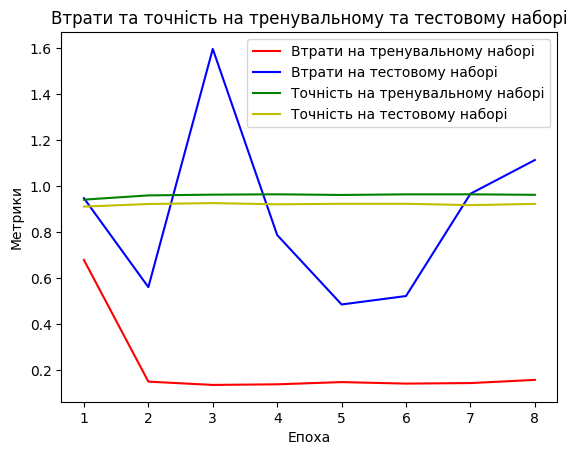

Parameters {'epochs': 10, 'batch_size': 128, 'dropout_rate': 0.1, 'loss_function': 'sparse_categorical_crossentropy', 'optimizer': 'rmsprop', 'metrics': ['accuracy']}
test_loss = 1.596444010734558
test_acc = 0.925599992275238
train_loss = 0.12283574044704437
train_acc = 0.9730666875839233
Optimal value for parameter loss_function: sparse_categorical_crossentropy, test accuracy: 0.925599992275238

Optimal parameters:
{'epochs': 10, 'batch_size': 128, 'dropout_rate': 0.1, 'loss_function': 'sparse_categorical_crossentropy', 'optimizer': 'rmsprop', 'metrics': ['accuracy']}
Test accuracy: 0.925599992275238


In [18]:
find_optimal_2 = find_optimal_parameters(train_images, train_labels, test_images, test_labels, parameters, optimal_parameters, study_sequence, train_model_2)


**Ініціалізація і перевірка моделі 3**

---


In [10]:
def train_model_3(train_images, train_labels, test_images, test_labels, base_model=base_model_vgg16, epochs=20, batch_size=32, dropout_rate=0.1,
                loss_function='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy']):
    #base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

    base_model.trainable = True
    set_trainable = False

    for layer in base_model_vgg16.layers:
        if layer.name == "block5_conv1":
            set_trainable = True
        if layer.name == "block5_conv2":
            set_trainable = True
        if layer.name == "block5_conv3":
            set_trainable = True
        if set_trainable:
            layer.trainable = True

        else:
            layer.trainable = False

    model = models.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(dropout_rate),
        layers.Dense(10, activation='softmax')
    ])

    early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

    model.compile(optimizer=optimizer,
                  loss=loss_function,
                  metrics=metrics)

    history = model.fit(train_images, train_labels, epochs=epochs, batch_size=batch_size, validation_data=(test_images, test_labels), callbacks=[early_stopping])

    test_loss, test_acc = model.evaluate(test_images, test_labels)
    print('Точність на тестових даних:', test_acc)

    train_loss, train_acc = model.evaluate(train_images, train_labels)
    print('Точність на тренувальних даних:', train_acc)

    return model, history, (test_loss, test_acc), (train_loss, train_acc)




In [11]:
model_3_testing = train_model_3(train_images, train_labels, test_images, test_labels,
                              base_model=base_model_vgg16,
                              epochs=20,
                              batch_size=32,
                              dropout_rate=0.1,
                              loss_function='sparse_categorical_crossentropy',
                              optimizer='adam',
                              metrics=['accuracy'])

Epoch 1/20
1875/1875 [==============================] - 39s 17ms/step - loss: 0.4766 - accuracy: 0.8341 - val_loss: 0.3644 - val_accuracy: 0.8674
Epoch 2/20
1875/1875 [==============================] - 30s 16ms/step - loss: 0.3261 - accuracy: 0.8866 - val_loss: 0.3152 - val_accuracy: 0.8925
Epoch 3/20
1875/1875 [==============================] - 29s 16ms/step - loss: 0.2960 - accuracy: 0.8965 - val_loss: 0.3399 - val_accuracy: 0.8843
Epoch 4/20
1875/1875 [==============================] - 29s 16ms/step - loss: 0.2766 - accuracy: 0.9027 - val_loss: 0.3140 - val_accuracy: 0.8988
Epoch 5/20
1875/1875 [==============================] - 29s 15ms/step - loss: 0.2587 - accuracy: 0.9106 - val_loss: 0.3160 - val_accuracy: 0.8952
Epoch 6/20
1875/1875 [==============================] - 30s 16ms/step - loss: 0.2493 - accuracy: 0.9126 - val_loss: 0.3235 - val_accuracy: 0.8945
Epoch 7/20
1875/1875 [==============================] - 30s 16ms/step - loss: 0.2341 - accuracy: 0.9161 - val_loss: 0.3040 -

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 64)                32832     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                650       
                                                                 
Total params: 14748170 (56.26 MB)
Trainable params: 7112906 (27.13 MB)
Non-trainable params: 7635264 (29.13 MB)
_________________________________________________________________


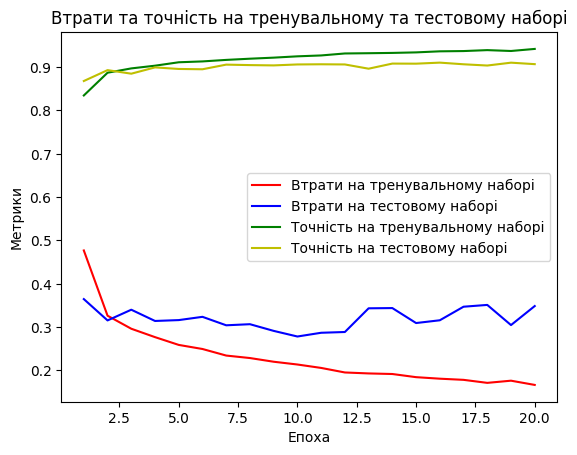

In [12]:
model_3_testing[0].summary()
plot_history(model_3_testing[1])


Searching for optimal value for parameter: optimizer
Testing value: adam
Epoch 1/10
469/469 [==============================] - 16s 23ms/step - loss: 0.8689 - accuracy: 0.6617 - val_loss: 0.5013 - val_accuracy: 0.8340
Epoch 2/10
469/469 [==============================] - 10s 22ms/step - loss: 0.3392 - accuracy: 0.8828 - val_loss: 0.3265 - val_accuracy: 0.8856
Epoch 3/10
469/469 [==============================] - 10s 21ms/step - loss: 0.2666 - accuracy: 0.9097 - val_loss: 0.2673 - val_accuracy: 0.9082
Epoch 4/10
469/469 [==============================] - 10s 22ms/step - loss: 0.2283 - accuracy: 0.9204 - val_loss: 0.2938 - val_accuracy: 0.9036
Epoch 5/10
469/469 [==============================] - 10s 21ms/step - loss: 0.2193 - accuracy: 0.9246 - val_loss: 0.3092 - val_accuracy: 0.9004
Epoch 6/10
469/469 [==============================] - 11s 22ms/step - loss: 0.1988 - accuracy: 0.9314 - val_loss: 0.2202 - val_accuracy: 0.9292
Epoch 7/10
469/469 [==============================] - 10s 22ms

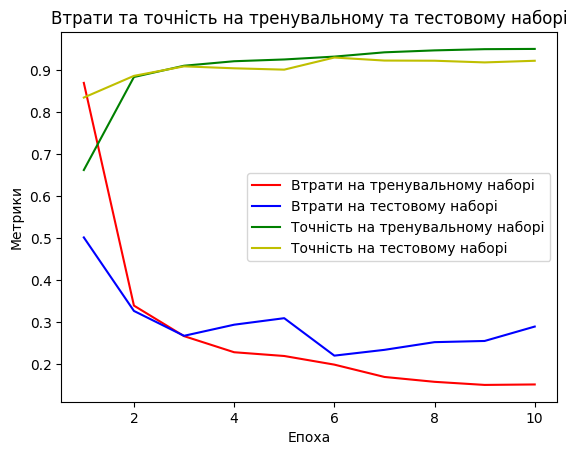

Parameters {'epochs': 10, 'batch_size': 128, 'dropout_rate': 0.1, 'loss_function': 'sparse_categorical_crossentropy', 'optimizer': 'adam', 'metrics': ['accuracy']}
test_loss = 0.28930723667144775
test_acc = 0.921500027179718
train_loss = 0.13084912300109863
train_acc = 0.9574166536331177
Testing value: rmsprop
Epoch 1/10
469/469 [==============================] - 14s 22ms/step - loss: 0.1681 - accuracy: 0.9514 - val_loss: 0.2920 - val_accuracy: 0.9175
Epoch 2/10
469/469 [==============================] - 10s 21ms/step - loss: 0.1083 - accuracy: 0.9637 - val_loss: 0.3240 - val_accuracy: 0.9313
Epoch 3/10
469/469 [==============================] - 10s 21ms/step - loss: 0.0990 - accuracy: 0.9679 - val_loss: 0.2830 - val_accuracy: 0.9247
Epoch 4/10
469/469 [==============================] - 10s 21ms/step - loss: 0.0907 - accuracy: 0.9711 - val_loss: 0.3096 - val_accuracy: 0.9267
Epoch 5/10
469/469 [==============================] - 10s 21ms/step - loss: 0.0843 - accuracy: 0.9730 - val_loss

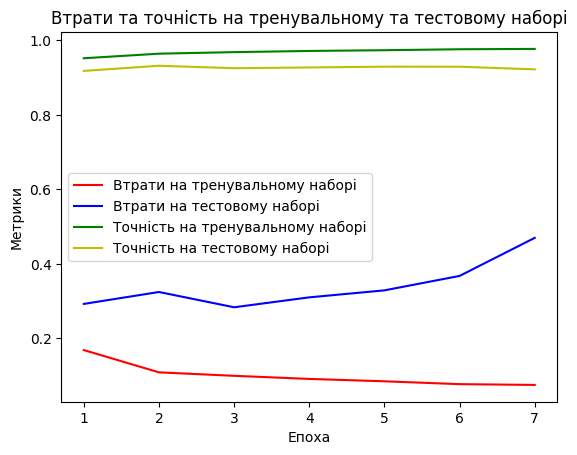

Parameters {'epochs': 10, 'batch_size': 128, 'dropout_rate': 0.1, 'loss_function': 'sparse_categorical_crossentropy', 'optimizer': 'rmsprop', 'metrics': ['accuracy']}
test_loss = 0.3239941895008087
test_acc = 0.9312999844551086
train_loss = 0.07753527909517288
train_acc = 0.9740999937057495
Optimal value for parameter optimizer: rmsprop, test accuracy: 0.9312999844551086


Searching for optimal value for parameter: dropout_rate
Testing value: 0.2
Epoch 1/10
469/469 [==============================] - 13s 22ms/step - loss: 0.1609 - accuracy: 0.9585 - val_loss: 0.3127 - val_accuracy: 0.9266
Epoch 2/10
469/469 [==============================] - 9s 20ms/step - loss: 0.0945 - accuracy: 0.9704 - val_loss: 0.3400 - val_accuracy: 0.9262
Epoch 3/10
469/469 [==============================] - 9s 20ms/step - loss: 0.0878 - accuracy: 0.9730 - val_loss: 0.3360 - val_accuracy: 0.9291
Epoch 4/10
469/469 [==============================] - 10s 20ms/step - loss: 0.0835 - accuracy: 0.9749 - val_loss: 0.331

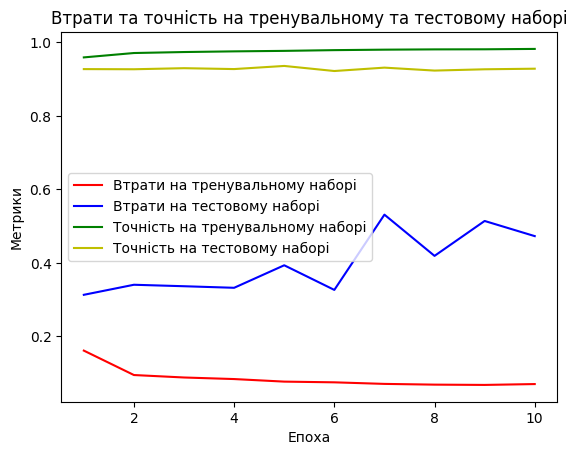

Parameters {'epochs': 10, 'batch_size': 128, 'dropout_rate': 0.2, 'loss_function': 'sparse_categorical_crossentropy', 'optimizer': 'rmsprop', 'metrics': ['accuracy']}
test_loss = 0.39301422238349915
test_acc = 0.9351999759674072
train_loss = 0.046075239777565
train_acc = 0.9846333265304565
Testing value: 0.3
Epoch 1/10
469/469 [==============================] - 12s 21ms/step - loss: 0.1260 - accuracy: 0.9696 - val_loss: 0.3838 - val_accuracy: 0.9278
Epoch 2/10
469/469 [==============================] - 10s 21ms/step - loss: 0.0779 - accuracy: 0.9772 - val_loss: 0.5045 - val_accuracy: 0.9303
Epoch 3/10
469/469 [==============================] - 9s 20ms/step - loss: 0.0735 - accuracy: 0.9791 - val_loss: 0.4404 - val_accuracy: 0.9273
Epoch 4/10
469/469 [==============================] - 10s 21ms/step - loss: 0.0721 - accuracy: 0.9801 - val_loss: 0.5190 - val_accuracy: 0.9318
Epoch 5/10
469/469 [==============================] - 10s 21ms/step - loss: 0.0709 - accuracy: 0.9812 - val_loss: 0

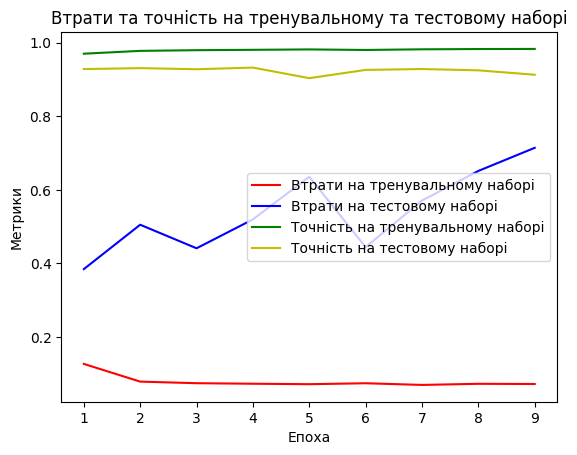

Parameters {'epochs': 10, 'batch_size': 128, 'dropout_rate': 0.3, 'loss_function': 'sparse_categorical_crossentropy', 'optimizer': 'rmsprop', 'metrics': ['accuracy']}
test_loss = 0.5189504623413086
test_acc = 0.9318000078201294
train_loss = 0.0448879674077034
train_acc = 0.987500011920929
Testing value: 0.4
Epoch 1/10
469/469 [==============================] - 13s 21ms/step - loss: 0.1504 - accuracy: 0.9713 - val_loss: 0.4591 - val_accuracy: 0.9176
Epoch 2/10
469/469 [==============================] - 9s 20ms/step - loss: 0.0743 - accuracy: 0.9812 - val_loss: 0.5275 - val_accuracy: 0.9315
Epoch 3/10
469/469 [==============================] - 10s 21ms/step - loss: 0.0750 - accuracy: 0.9806 - val_loss: 0.5107 - val_accuracy: 0.9296
Epoch 4/10
469/469 [==============================] - 10s 21ms/step - loss: 0.0713 - accuracy: 0.9830 - val_loss: 0.6043 - val_accuracy: 0.9272
Epoch 5/10
469/469 [==============================] - 10s 20ms/step - loss: 0.0671 - accuracy: 0.9828 - val_loss: 0.

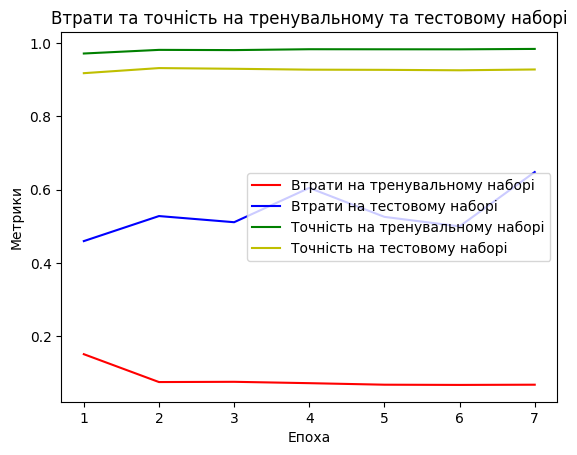

Parameters {'epochs': 10, 'batch_size': 128, 'dropout_rate': 0.4, 'loss_function': 'sparse_categorical_crossentropy', 'optimizer': 'rmsprop', 'metrics': ['accuracy']}
test_loss = 0.5275153517723083
test_acc = 0.9315000176429749
train_loss = 0.03759981319308281
train_acc = 0.9891499876976013
Optimal value for parameter dropout_rate: 0.2, test accuracy: 0.9351999759674072


Searching for optimal value for parameter: batch_size
Testing value: 32
Epoch 1/10
1875/1875 [==============================] - 24s 11ms/step - loss: 0.2106 - accuracy: 0.9499 - val_loss: 0.5023 - val_accuracy: 0.9182
Epoch 2/10
1875/1875 [==============================] - 20s 11ms/step - loss: 0.2455 - accuracy: 0.9393 - val_loss: 0.4503 - val_accuracy: 0.8955
Epoch 3/10
1875/1875 [==============================] - 20s 11ms/step - loss: 0.3015 - accuracy: 0.9253 - val_loss: 0.4176 - val_accuracy: 0.9006
Epoch 4/10
1875/1875 [==============================] - 20s 11ms/step - loss: 0.4019 - accuracy: 0.9054 - val_loss:

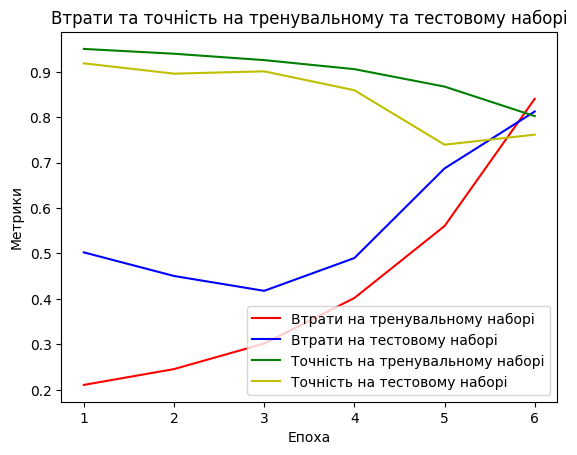

Parameters {'epochs': 10, 'batch_size': 32, 'dropout_rate': 0.2, 'loss_function': 'sparse_categorical_crossentropy', 'optimizer': 'rmsprop', 'metrics': ['accuracy']}
test_loss = 0.5022802352905273
test_acc = 0.9182000160217285
train_loss = 0.17446266114711761
train_acc = 0.9527166485786438
Testing value: 64
Epoch 1/10
938/938 [==============================] - 18s 15ms/step - loss: 0.1884 - accuracy: 0.9562 - val_loss: 0.3563 - val_accuracy: 0.9234
Epoch 2/10
938/938 [==============================] - 14s 15ms/step - loss: 0.1341 - accuracy: 0.9648 - val_loss: 0.7214 - val_accuracy: 0.9201
Epoch 3/10
938/938 [==============================] - 14s 15ms/step - loss: 0.1336 - accuracy: 0.9640 - val_loss: 0.5648 - val_accuracy: 0.9237
Epoch 4/10
938/938 [==============================] - 13s 14ms/step - loss: 0.1419 - accuracy: 0.9653 - val_loss: 0.5458 - val_accuracy: 0.9194
Epoch 5/10
938/938 [==============================] - 13s 14ms/step - loss: 0.1488 - accuracy: 0.9623 - val_loss: 0

In [ ]:
find_optimal_3 = find_optimal_parameters(train_images, train_labels, test_images, test_labels, parameters, optimal_parameters, study_sequence, train_model_3)



Висновок

Під час використання техніки перенесення навчання з використанням натренованої моделі VGG16, виявлено, що результати стають задовільними при розмороженні та пренавчанні деяких внутрішніх шарів. Однак зміни у верхніх рівнях мережі не призвели до суттєвого поліпшення результатів. З іншого боку, використання моделі VGG16 без розмороження рівнів привело до більш стабільних результатів, що демонструється на графіках точності та втрат для тренувальних та тестових даних.
